<a href="https://colab.research.google.com/github/eh3323/Repos_and_Projects/blob/main/SpeechGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!apt-get update -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [12]:
!apt-get install -y fonts-noto-cjk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 2s (26.3 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [13]:
from matplotlib import font_manager as fm

# 列出 ttc/ttf/otf 文件
paths = fm.findSystemFonts(fontpaths=None, fontext='ttf') + fm.findSystemFonts(fontpaths=None, fontext='otf') + fm.findSystemFonts(fontpaths=None, fontext='ttc')
# 过滤可能含“noto”、“cjk”等关键字的字体
cjk_fonts = [fp for fp in paths if any(sub in fp.lower() for sub in ['noto', 'cjk', 'arphic', 'wqy'])]
print("可能的中文字体路径：")
for fp in cjk_fonts:
    try:
        prop = fm.FontProperties(fname=fp)
        print(fp, "->", prop.get_name())
    except Exception:
        print(fp, "-> 无法解析名称")


可能的中文字体路径：
/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc -> Noto Serif CJK JP
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc -> Noto Serif CJK JP
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc -> Noto Sans CJK JP
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc -> Noto Sans CJK JP
/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc -> Noto Serif CJK JP
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc -> Noto Serif CJK JP
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc -> Noto Sans CJK JP
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc -> Noto Sans CJK JP
/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc -> Noto Serif CJK JP
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc -> Noto Serif CJK JP
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc -> Noto Sans CJK JP
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc -> Noto Sans CJK JP


使用中文字体: Noto Serif CJK JP


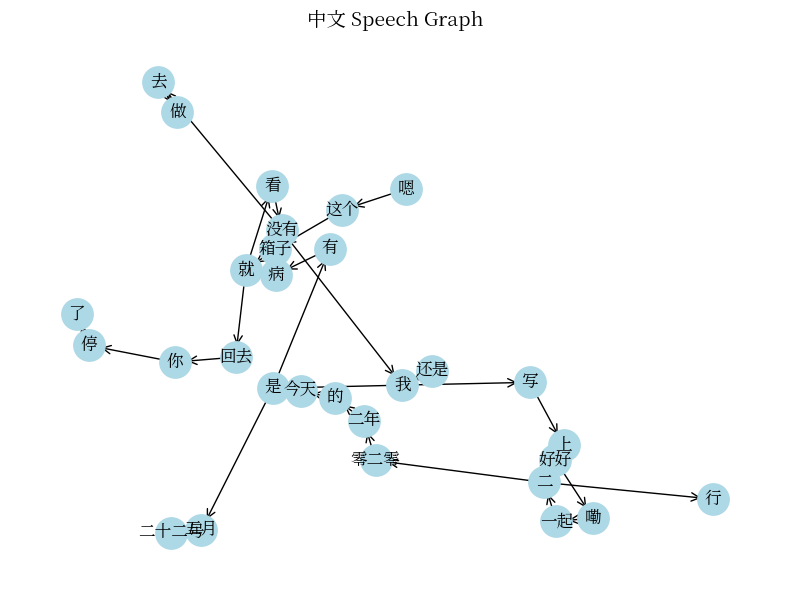

In [23]:
import os
import re
import jieba
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 找到字体路径 (可以手动指定，或用 font_manager 搜索)
font_path = "/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc"
if not os.path.exists(font_path):
    # 如果路径不同，可以在此打印可用中文字体路径
    print("未找到预期路径，请检查实际字体位置或用 font_manager 搜索。")
else:
    fm.fontManager.addfont(font_path)
    prop = fm.FontProperties(fname=font_path)
    font_name = prop.get_name()
    print("使用中文字体:", font_name)
    plt.rcParams['font.family'] = font_name
    plt.rcParams['font.sans-serif'] = [font_name]
    plt.rcParams['axes.unicode_minus'] = False

#示例文本（你的 ASR 转录结果）
text = "还是我写上二零二零二年的，今天是五月二十二号。好好嘞，一起二行。没有，我是有病，就看没有去做。嗯，这个箱子就回去，你停了。"

# 分句与分词
sentences = re.split(r'[。！？；\n]', text)
G = nx.DiGraph()
for sent in sentences:
    sent = sent.strip()
    if not sent:
        continue
    tokens = [w for w in jieba.lcut(sent) if w.strip() and not re.match(r'[\s,，。！？；]', w)]
    # 可选：过滤停用词
    # stopwords = set([...])
    # tokens = [w for w in tokens if w not in stopwords]
    for i in range(len(tokens) - 1):
        u, v = tokens[i], tokens[i + 1]
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

# 可视化
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=510, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15)
labels = {node: node for node in G.nodes()}
# 直接绘制，使用全局已设置的 font.family
nx.draw_networkx_labels(G, pos, labels, font_size=12)
plt.title("中文 Speech Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [25]:
import networkx as nx
import numpy as np
import jieba
import re
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

def analyze_graph(G: nx.DiGraph):
    """
    Analyze a directed graph G and compute properties similar to speechgraph metrics:
    - number_of_nodes: total nodes
    - number_of_edges: total edges
    - number_of_self_loops: count of self-loops
    - degree_average: average degree (in+out)
    - degree_std: std deviation of degrees
    - LCC: size of largest weakly connected component
    - LSC: size of largest strongly connected component
    - num_2_cycles: count of 2-node cycles (reciprocal edges)
    - num_3_cycles: count of 3-node directed cycles (triangles) (may be expensive)
    - reciprocal_edge_pairs: list of node pairs with reciprocal edges
    """
    # Nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Self-loops
    num_self_loops = nx.number_of_selfloops(G)

    # Degrees: for directed, degree() returns in+out
    degrees = np.array([d for _, d in G.degree()])
    degree_average = float(np.mean(degrees)) if len(degrees) > 0 else 0.0
    degree_std = float(np.std(degrees, ddof=0)) if len(degrees) > 0 else 0.0

    # Largest Weakly Connected Component (LCC)
    if num_nodes > 0:
        weak_comps = list(nx.weakly_connected_components(G))
        LCC = max((len(c) for c in weak_comps), default=0)
    else:
        LCC = 0

    # Largest Strongly Connected Component (LSC)
    if num_nodes > 0:
        strong_comps = list(nx.strongly_connected_components(G))
        LSC = max((len(c) for c in strong_comps), default=0)
    else:
        LSC = 0

    # 2-node cycles (reciprocal edges)
    reciprocal_pairs = set()
    for u, v in G.edges():
        if u != v and G.has_edge(v, u):
            pair = tuple(sorted((u, v)))
            reciprocal_pairs.add(pair)
    num_2_cycles = len(reciprocal_pairs)

    # 3-node cycles (triangles). Use networkx.simple_cycles (可能对大图较慢)
    num_3_cycles = 0
    try:
        seen = set()
        for cycle in nx.simple_cycles(G):
            if len(cycle) == 3:
                # 对 cycle 中的节点排序，以避免同一循环不同起点重复计数
                sorted_cycle = tuple(sorted(cycle))
                if sorted_cycle not in seen:
                    seen.add(sorted_cycle)
                    num_3_cycles += 1
    except Exception as e:
        print(f"Warning: counting 3-cycles 失败或开销过大: {e}")
        num_3_cycles = None

    summary = {
        'number_of_nodes': num_nodes,
        'number_of_edges': num_edges,
        'number_of_self_loops': num_self_loops,
        'degree_average': degree_average,
        'degree_std': degree_std,
        'LCC': LCC,
        'LSC': LSC,
        'num_2_cycles': num_2_cycles,
        'num_3_cycles': num_3_cycles,
        # 如需看具体互向边对，可查看下面列表；若仅要数量，可忽略此字段
        'reciprocal_edge_pairs': list(reciprocal_pairs)
    }
    return summary

# --------------------------------------------------------------------
# 构建示例：如何从文本生成 DiGraph，并调用 analyze_graph
# --------------------------------------------------------------------
def build_text_graph(text: str, by_word=True, stopwords=None):
    """
    根据中文文本构建一个有向图（类似 SpeechGraph 的 Naive Graph）。
    by_word=True 时使用 jieba 分词，否则按字符拆分（除去空白/标点）。
    stopwords: 可选中文停用词集合，用于过滤高频无意义 token。
    """
    G = nx.DiGraph()
    # 分句（依据中文标点），也可自定义
    sentences = re.split(r'[。！？；\n]', text)
    for sent in sentences:
        sent = sent.strip()
        if not sent:
            continue
        if by_word:
            tokens = [w for w in jieba.lcut(sent) if w.strip() and not re.match(r'[\s,，。！？；]', w)]
        else:
            # 按字拆分，过滤空白或标点
            tokens = [ch for ch in sent if not ch.isspace() and not re.match(r'[\s,，。！？；]', ch)]
        if stopwords:
            tokens = [w for w in tokens if w not in stopwords]
        # 添加有向边：相邻 token
        for i in range(len(tokens) - 1):
            u, v = tokens[i], tokens[i + 1]
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1
            else:
                G.add_edge(u, v, weight=1)
    return G

# --------------------------------------------------------------------
# 在 Colab 或本地运行示例
# --------------------------------------------------------------------
if __name__ == "__main__":
    # 如果在 Colab，先安装依赖：
    # !pip install jieba networkx numpy matplotlib

    # 示例文本，可以替换为你的 ASR 转录文本
    example_text = "还是我写上二零二零二年的，今天是五月二十二号。好好嘞，一起二行。没有，我是有病，就看没有去做。嗯，这个箱子就回去，你停了。"

    # 构建图
    G = build_text_graph(example_text, by_word=True)

    # 分析图性质
    summary = analyze_graph(G)

    # 打印结果
    import pprint
    pprint.pprint(summary)


{'LCC': 30,
 'LSC': 14,
 'degree_average': 2.066666666666667,
 'degree_std': 0.8919392106839769,
 'num_2_cycles': 0,
 'num_3_cycles': 0,
 'number_of_edges': 31,
 'number_of_nodes': 30,
 'number_of_self_loops': 0,
 'reciprocal_edge_pairs': []}
